In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
def shorten_model_name(name):
    name = name.replace("Qwen/Qwen2.5-VL-7B-Instruct", "Qwen7B")
    name = name.replace("OpenGVLab/InternVL3-8B", "Intern8B")
    name = name.replace("llava-hf/llava-v1.6-mistral-7b-hf", "LLaVA7B")
    return name


def fill_correct(df, half_scores = False):
    df = df.copy()
    if half_scores:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right'
            else 0.5 if str(x).strip().lower() == 'somewhat right' 
            else 0
            )
    else:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right' 
            else 0
        )
    return df

def clean_df(df, subset_cols,):
    df = df.copy()
    df = df.dropna(subset=subset_cols).drop_duplicates(subset=subset_cols, keep='last')
    return df

def prepare_df(df, half_scores = False):
    df = df.copy()
    df = fill_correct(df, half_scores=half_scores)
    ensemble_subset_cols = [
            "problem_id",
            "dataset_name",
            "type_name",
            "version",
        ]
    
    single_subset_cols = [
            "problem_id",
            "dataset_name",
            "model_name",
            "strategy_name",
            "version"
        ]
    df_singles = df[df["ensemble"] == False]
    df_singles = clean_df(df_singles, subset_cols=single_subset_cols)
    df_ensembles = df[df["ensemble"] == True]
    df_ensembles = clean_df(df_ensembles, subset_cols=ensemble_subset_cols)
    return df_singles, df_ensembles

In [ ]:
df = pd.read_csv('../results/all_results_concat.csv')
df, df_ensembles = prepare_df(df, half_scores=True)
df_no_half_scores, df_ensembles_no_half_scores = prepare_df(df, half_scores=False)

## Top models

In [4]:
def accuracy_stats(
    df,
    group_cols,
    versions=None,
    top_n=None,
    bottom_n=None
):

    df = df.copy()

    if versions is not None:
        df = df[df["version"].isin(versions)]

    grouped = df.groupby(group_cols)["is_correct"]

    score = grouped.sum()
    total = grouped.count()

    percentage = score / total * 100

    results = pd.DataFrame({
        "total_score": score,
        "all_possible": total,
        "percentage": percentage
    }).reset_index()

    accuracy_stats = results.sort_values("percentage", ascending=False)
    # Sort
    if top_n is not None:
        top = results.sort_values("percentage", ascending=False).head(top_n)
        print(f"\nTop {top_n}:")
        print(top)
    
    if bottom_n is not None:
        bottom = results.sort_values("percentage", ascending=True).head(bottom_n)
        print(f"\nBottom {bottom_n}:")
        print(bottom)

    # ---- Top K list in requested format ----
    # top_k_list = [
    #     [str(row[col]) for col in group_cols]
    #     for _, row in accuracy_stats.head(top_n).iterrows()
    # ]

    # print(f"\nTop {top_n} {[f'{c}' for c in group_cols]}:")
    # print(top_k_list)

    return accuracy_stats


In [14]:
group_cols=["strategy_name", "model_name", "version", "dataset_name"]
accuracy_df = accuracy_stats(df, group_cols=group_cols)


print("\n ------------ Average across all datasets -------------\n")
agg_group_cols = ["strategy_name", "model_name", "version"]
mean_accuracy = accuracy_df[accuracy_df["version"].isin([1,3])].groupby(agg_group_cols).agg(
    mean_percentage=("percentage", "mean"),
    sd_percentage=("percentage", "std"),
    total_score=("total_score", "sum"),
    total_possible=("all_possible", "sum")
).reset_index()
print(mean_accuracy.sort_values("mean_percentage", ascending=False))


bp_only = df[df["dataset_name"]=="bp"].copy()
bp_only = bp_only[bp_only["strategy_name"]!="classification"]
cvr_only = df[df["dataset_name"]=="cvr"].copy()
raven_only = df[df["dataset_name"]=="raven"].copy()
mars_only = df[df["dataset_name"]=="marsvqa"].copy()

print("\n ------------ BP -------------\n")
accuracy_df_bp = accuracy_stats(bp_only, group_cols=group_cols, top_n=5, bottom_n=5)
print("\n ------------ CVR -------------\n")
accuracy_df_cvr = accuracy_stats(cvr_only, group_cols=group_cols, top_n=5, bottom_n=5)
print("\n ------------ RAVEN -------------\n")
accuracy_df_raven = accuracy_stats(raven_only, group_cols=group_cols, top_n=5, bottom_n=5)
print("\n ------------ MARS -------------\n")
accuracy_df_mars = accuracy_stats(mars_only, group_cols=group_cols, top_n=5, bottom_n=5)


 ------------ Average across all datasets -------------

     strategy_name                         model_name  version  \
21          direct        Qwen/Qwen2.5-VL-7B-Instruct        3   
9      contrastive        Qwen/Qwen2.5-VL-7B-Instruct        3   
20          direct        Qwen/Qwen2.5-VL-7B-Instruct        1   
8      contrastive        Qwen/Qwen2.5-VL-7B-Instruct        1   
18          direct             OpenGVLab/InternVL3-8B        1   
12     descriptive             OpenGVLab/InternVL3-8B        1   
2   classification        Qwen/Qwen2.5-VL-7B-Instruct        1   
3   classification        Qwen/Qwen2.5-VL-7B-Instruct        3   
19          direct             OpenGVLab/InternVL3-8B        3   
13     descriptive             OpenGVLab/InternVL3-8B        3   
15     descriptive        Qwen/Qwen2.5-VL-7B-Instruct        3   
0   classification             OpenGVLab/InternVL3-8B        1   
1   classification             OpenGVLab/InternVL3-8B        3   
14     descriptive

In [59]:
def select_top(df, acc_group_cols, top_group_cols):
    df = df.copy()
    df = accuracy_stats(df, acc_group_cols)

    top_df = (
        df
        .sort_values("percentage", ascending=False)
        .groupby(top_group_cols)
        .first()
        .reset_index()
    )

    return top_df

In [60]:
acc_group_cols = ["strategy_name", "model_name", "version"]
top_group_cols = ["model_name", "strategy_name"]
select_top(df, acc_group_cols, top_group_cols)

,model_name,strategy_name,version,total_score,percentage
0,OpenGVLab/InternVL3-8B,classification,1,114.0,28.500
1,OpenGVLab/InternVL3-8B,contrastive,3,106.0,26.500
2,OpenGVLab/InternVL3-8B,descriptive,1,124.0,31.000
3,OpenGVLab/InternVL3-8B,direct,1,126.0,31.500
4,Qwen/Qwen2.5-VL-7B-Instruct,classification,1,122.0,30.500
5,Qwen/Qwen2.5-VL-7B-Instruct,contrastive,3,193.0,48.250
6,Qwen/Qwen2.5-VL-7B-Instruct,descriptive,3,115.5,28.875
7,Qwen/Qwen2.5-VL-7B-Instruct,direct,3,196.0,49.000
8,llava-hf/llava-v1.6-mistral-7b-hf,classification,3,104.0,26.000
9,llava-hf/llava-v1.6-mistral-7b-hf,contrastive,3,93.5,23.375


In [ ]:
top_group_cols = ["strategy_name", "model_name"]
select_top(df, acc_group_cols, top_group_cols)

,strategy_name,model_name,version,total_score,percentage
0,classification,OpenGVLab/InternVL3-8B,1,114.0,28.500
1,classification,Qwen/Qwen2.5-VL-7B-Instruct,1,122.0,30.500
2,classification,llava-hf/llava-v1.6-mistral-7b-hf,3,104.0,26.000
3,contrastive,OpenGVLab/InternVL3-8B,3,106.0,26.500
4,contrastive,Qwen/Qwen2.5-VL-7B-Instruct,3,193.0,48.250
5,contrastive,llava-hf/llava-v1.6-mistral-7b-hf,3,93.5,23.375
6,descriptive,OpenGVLab/InternVL3-8B,1,124.0,31.000
7,descriptive,Qwen/Qwen2.5-VL-7B-Instruct,3,115.5,28.875
8,descriptive,llava-hf/llava-v1.6-mistral-7b-hf,3,102.0,25.500
9,direct,OpenGVLab/InternVL3-8B,1,126.0,31.500


## Matrices

### Plotting

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def _problem_id(i, j, zero_indexed):
    return i * 10 + j if zero_indexed else i * 10 + j + 1

def _get_extremes(values, top_k=3):
    zero_cells = np.argwhere(values == 0)
    flat_indices = np.argsort(values, axis=None)[-top_k:]
    top_cells = [np.unravel_index(i, values.shape) for i in flat_indices]
    return zero_cells, top_cells

def _make_colormap():
    return LinearSegmentedColormap.from_list("white_to_green", ["#ffffff", "#006400"])

def _plot_heatmap(ax, values, title, max_score, zero_indexed, highlight_extremes, cmap):
    im = ax.imshow(values, cmap=cmap, vmin=0, vmax=max_score)
    zero_cells, top_cells = ([], [])
    if highlight_extremes:
        zero_cells, top_cells = _get_extremes(values)

    for i in range(10):
        for j in range(10):
            pid = _problem_id(i, j, zero_indexed)
            ax.text(j, i, str(pid), ha="center", va="center", fontsize=9)
            if highlight_extremes:
                if values[i, j] == 0:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor="red", linewidth=2))
                if (i, j) in top_cells:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor="blue", linewidth=2))

    ax.set_title(title)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(range(10) if zero_indexed else range(1, 11))
    return im, zero_cells, top_cells

def _plot_histogram(ax, values, max_score, font_size=10):
    flat_values = values.flatten()
    bins = np.arange(0, max_score + 2) - 0.5
    ax.hist(flat_values, bins=bins, color="#ced9f2", edgecolor="#08519c", linewidth=1, alpha=0.8)
    ax.set_xlim(-0.5, max_score + 0.5)
    ax.set_xlabel("is_correct score")
    ax.set_ylabel("Count")
    ax.set_title("Score distribution")


def generate_10x10_result_matrix(
    df,
    dataset_name=None,
    model_name=None,
    strategy_name=None,
    type_name=None,
    versions=None,
    zero_indexed_problem_ids=False
):
    df = df.copy()
    filters = {
        "dataset_name": dataset_name,
        "model_name": model_name,
        "strategy_name": strategy_name,
        "type_name": type_name,
        "version": versions,
    }

    for col, val in filters.items():
        if val is None:
            continue
        if isinstance(val, (list, tuple, set, range)):
            df = df[df[col].isin(val)]
        else:
            df = df[df[col] == val]

    scores = df.groupby("problem_id")["is_correct"].sum()
    offset = 0 if zero_indexed_problem_ids else 1

    matrix = pd.DataFrame(0, index=range(10), columns=range(10))
    for pid, score in scores.items():
        row, col = divmod(pid - offset, 10)
        if 0 <= row < 10 and 0 <= col < 10:
            matrix.iloc[row, col] = score

    matrix.index = [f"{i*10+1}-{i*10+10}" for i in range(10)]
    matrix.columns = [str(i+1) for i in range(10)]
    return matrix

def plot_10x10_matrices(
    matrices,
    titles,
    max_score=None,
    main_title="10x10 Matrices",
    highlight_extremes=False,
    zero_indexed_problem_ids=False,
    show_histograms=True,
    font_size=10
):
    assert 1 <= len(matrices) <= 3
    assert len(matrices) == len(titles)
    
    n = len(matrices)
    rows = 2 if show_histograms else 1
    max_score = max(matrix.values.max() for matrix in matrices) if max_score is None else max_score

    fig, axes = plt.subplots(
        rows, n,
        figsize=(6*n, 9 if show_histograms else 6),
        gridspec_kw={"height_ratios": [4,1]} if show_histograms else None,
        sharey="row"
    )

    plt.rcParams.update({'font.size': font_size})
    
    if n == 1:
        axes = axes.reshape(rows, 1)

    cmap = _make_colormap()

    for idx, (matrix, title) in enumerate(zip(matrices, titles)):
        heat_ax = axes[0, idx]
        hist_ax = axes[1, idx] if show_histograms else None
        values = matrix.values

        im, zero_cells, top_cells = _plot_heatmap(
            heat_ax, values, title, max_score, zero_indexed_problem_ids, highlight_extremes, cmap
        )

        if show_histograms:
            _plot_histogram(hist_ax, values, max_score, font_size=font_size)

        # Console summary
        if highlight_extremes:
            zero_ids = sorted(_problem_id(i,j,zero_indexed_problem_ids) for i,j in zero_cells)
            print(f"\n{title}\n{'-'*len(title)}")
            print(f"Zero-value problems : {len(zero_ids)} → {zero_ids if zero_ids else 'None'}")
            print("Top problems (problem_id : is_correct)")
            for i,j in top_cells:
                pid = _problem_id(i,j,zero_indexed_problem_ids)
                print(f"  → {pid} : {values[i,j]}")

    # Y-axis labels
    axes[0,0].set_yticklabels([f"{i*10+1}-{i*10+10}" for i in range(10)] if not zero_indexed_problem_ids else [f"{i*10}-{i*10+9}" for i in range(10)])
    axes[0,0].set_ylabel("Problem ID range")
    for col in range(n):
        axes[0,col].set_xlabel("Problem (within block)")

    # Colorbar
    cbar = fig.colorbar(im, ax=axes[0,:], fraction=0.035, pad=0.04)
    cbar.set_label("Sum of is_correct")
    fig.suptitle(main_title, fontsize=14)
    plt.show()

def plot_histograms(matrices, titles, max_score=None, main_title="Histograms"):
    assert 1 <= len(matrices) <= 3
    assert len(matrices) == len(titles)

    max_score = max(matrix.values.max() for matrix in matrices) if max_score is None else max_score
    n = len(matrices)

    fig, axes = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)
    if n == 1:
        axes = [axes]
    for idx, (matrix, title) in enumerate(zip(matrices, titles)):
        values = matrix.values
        _plot_histogram(axes[idx], values, max_score)
        axes[idx].set_title(title)
    fig.suptitle(main_title, fontsize=14)
    plt.show()

### Matrices - datasets


CVR
---
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 99 : 12
  → 82 : 13
  → 64 : 14

RAVEN
-----
Zero-value problems : 1 → [np.int64(38)]
Top problems (problem_id : is_correct)
  → 23 : 10
  → 28 : 10
  → 21 : 11

MARS
----
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 88 : 12
  → 71 : 12
  → 59 : 15


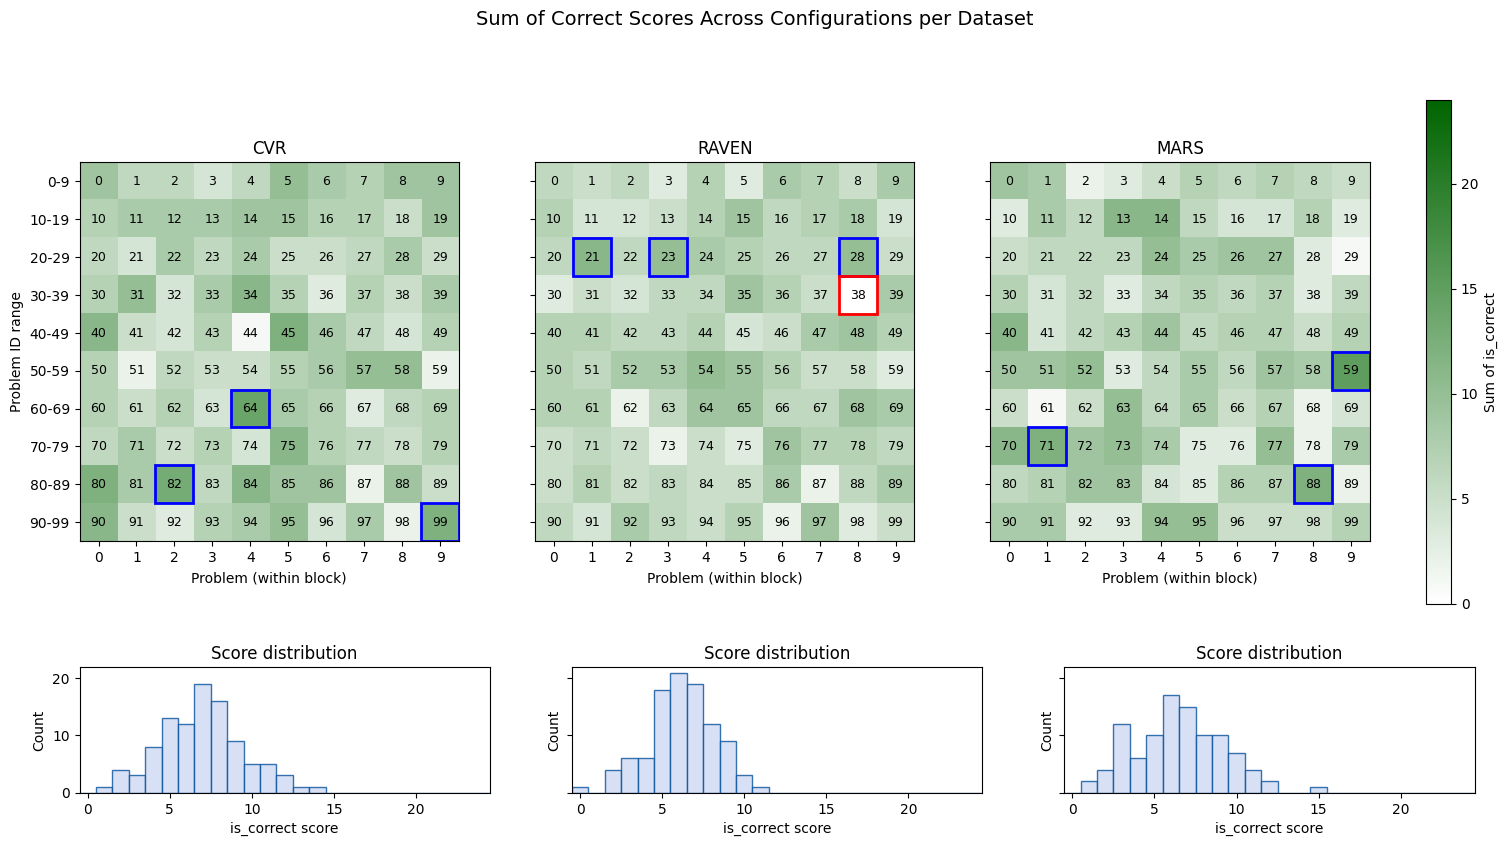

In [56]:
m1 = generate_10x10_result_matrix(df, dataset_name="cvr", versions=[1,3], zero_indexed_problem_ids=True)
m2 = generate_10x10_result_matrix(df, dataset_name="raven", versions=[1,3], zero_indexed_problem_ids=True)
m3 = generate_10x10_result_matrix(df, dataset_name="marsvqa", versions=[1,3], zero_indexed_problem_ids=True)
plot_10x10_matrices([m1,m2,m3],["CVR", "RAVEN", "MARS"],max_score=24, main_title="Sum of Correct Scores Across Configurations per Dataset",highlight_extremes=True, zero_indexed_problem_ids=True)
# plot_10x10_matrices([m1,m2],["CVR", "RAVEN"],max_score=24, main_title="Problem Accuracy per dataset",highlight_extremes=True, zero_indexed_problem_ids=True)
# plot_10x10_matrices([m3],["MARS"],max_score=24, main_title="Problem Accuracy Distribution per dataset")


BP
--
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 77 : 15.0
  → 83 : 15.5
  → 47 : 15.5


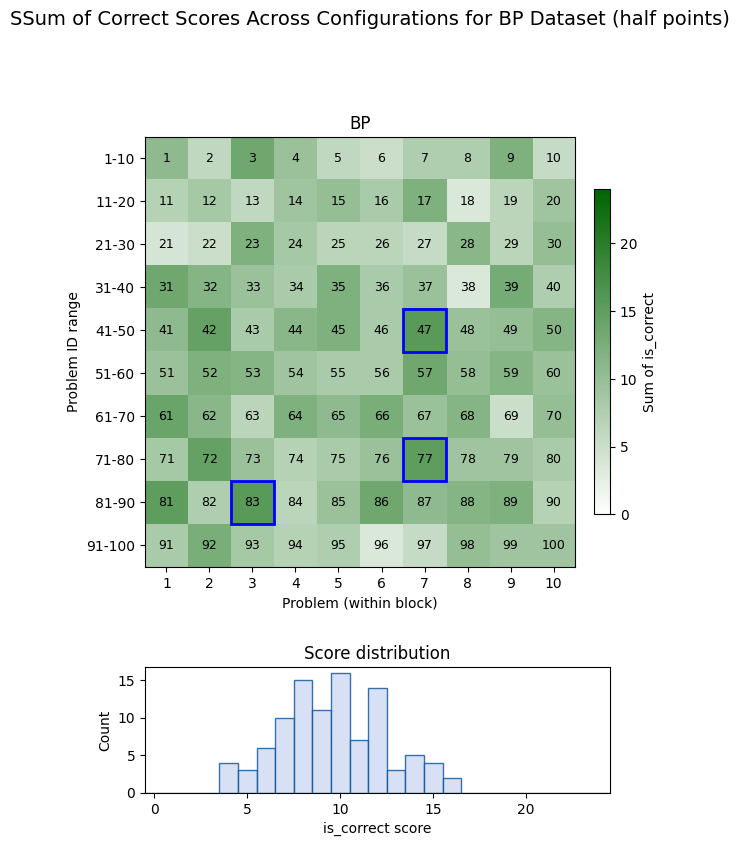

In [57]:
m1 = generate_10x10_result_matrix(df, dataset_name="bp", versions=[1,3])
plot_10x10_matrices([m1],["BP"],max_score=24, main_title="SSum of Correct Scores Across Configurations for BP Dataset (half points)",highlight_extremes=True)


BP
--
Zero-value problems : 7 → [np.int64(11), np.int64(18), np.int64(21), np.int64(27), np.int64(38), np.int64(94), np.int64(95)]
Top problems (problem_id : is_correct)
  → 81 : 8
  → 57 : 9
  → 47 : 10


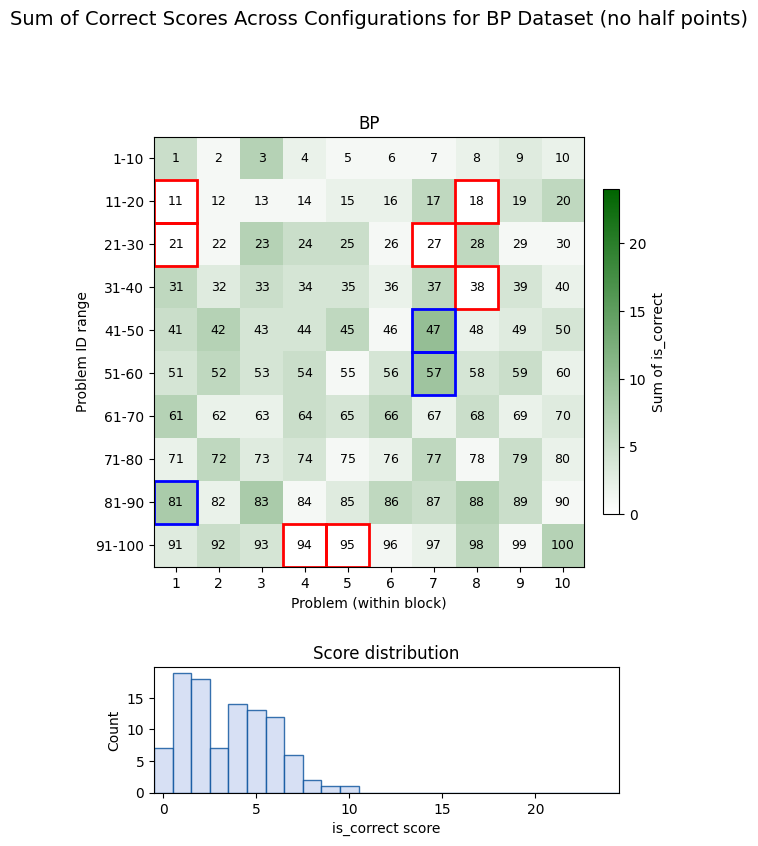

In [58]:
m1 = generate_10x10_result_matrix(df_no_half_scores, dataset_name="bp", versions=[1,3])
plot_10x10_matrices([m1],["BP"],max_score=24, main_title="Sum of Correct Scores Across Configurations for BP Dataset (no half points)",highlight_extremes=True)


BP
--
Zero-value problems : 2 → [np.int64(21), np.int64(27)]
Top problems (problem_id : is_correct)
  → 81 : 11
  → 3 : 13
  → 47 : 14


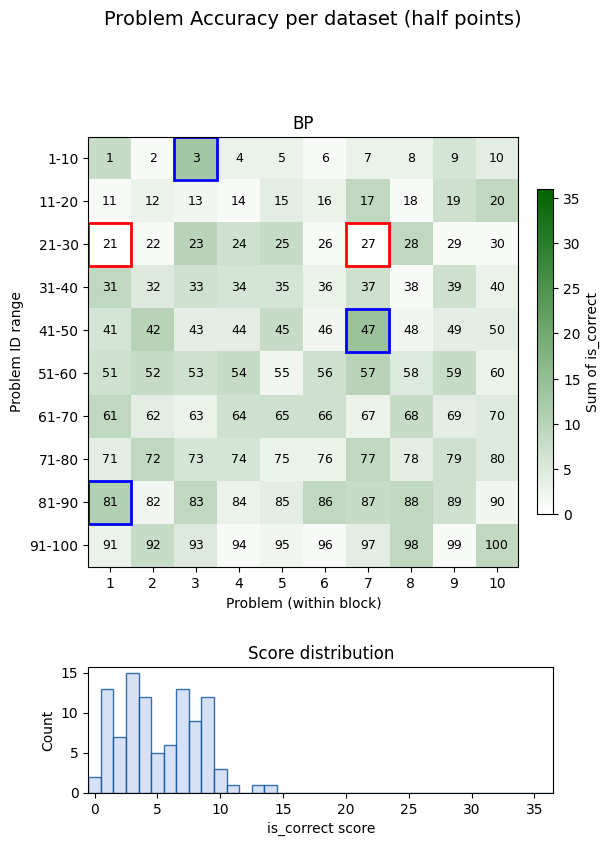

In [289]:
m1 = generate_10x10_result_matrix(df_no_half_scores, dataset_name="bp")
plot_10x10_matrices([m1],["BP"], max_score=36, main_title="Problem Accuracy per dataset (half points)", highlight_extremes=True)

### Matrices - models


Qwen
----
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 49 : 19.5
  → 23 : 20.0
  → 38 : 21.0

Intern
------
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 8 : 16.0
  → 85 : 17.0
  → 63 : 17.0

Llava
-----
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 82 : 12.0
  → 0 : 12.0
  → 24 : 13.0


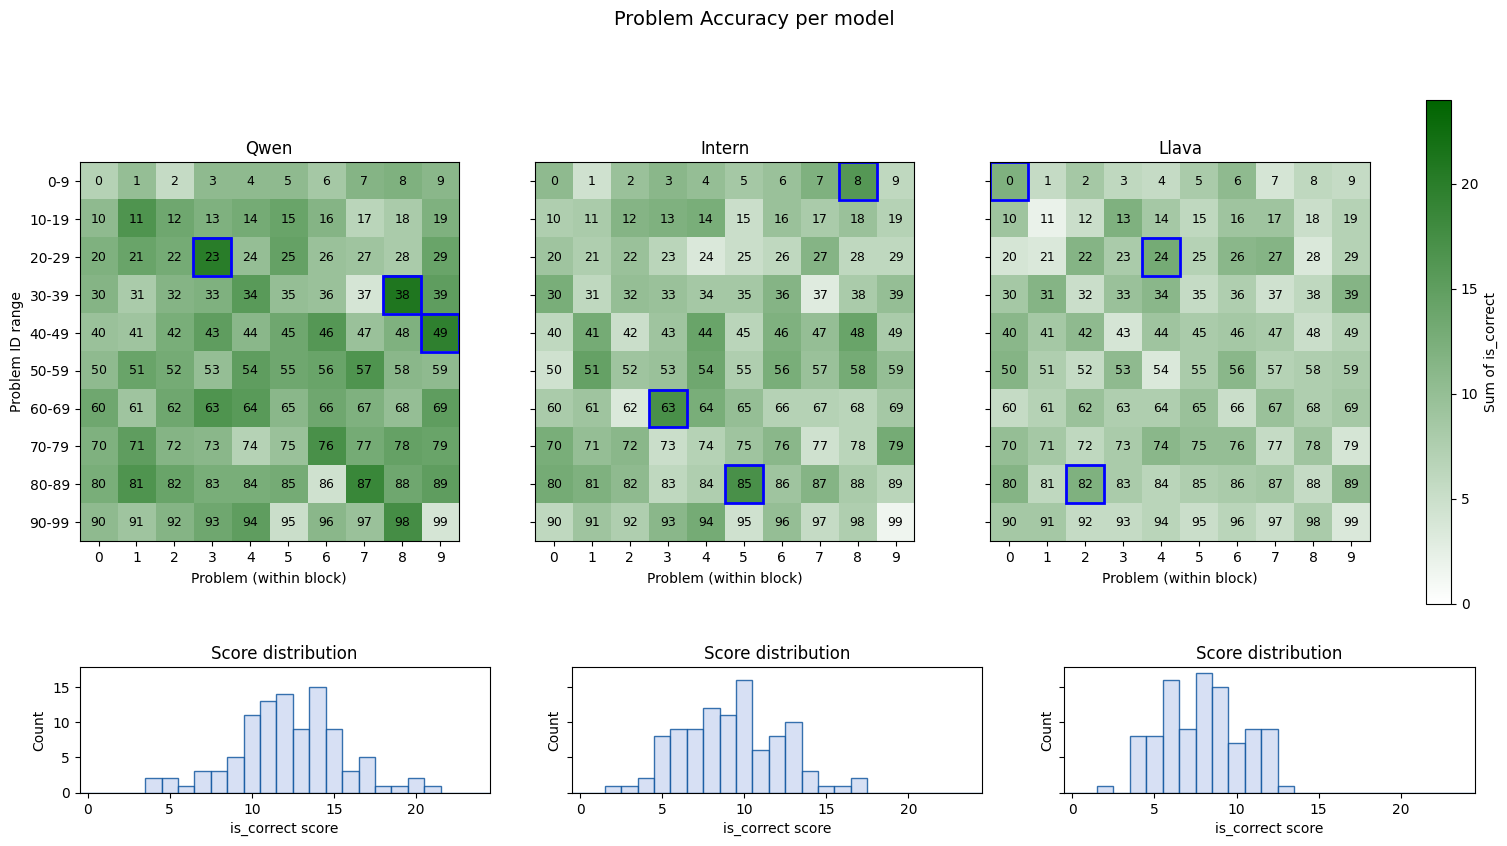

In [34]:
# 'Qwen/Qwen2.5-VL-7B-Instruct', 'llava-hf/llava-v1.6-mistral-7b-hf', 'OpenGVLab/InternVL3-8B'
m1 = generate_10x10_result_matrix(df, model_name="Qwen/Qwen2.5-VL-7B-Instruct", versions=[1,3])
m2 = generate_10x10_result_matrix(df, model_name="OpenGVLab/InternVL3-8B", versions=[1,3])
m3 = generate_10x10_result_matrix(df, model_name="llava-hf/llava-v1.6-mistral-7b-hf", versions=[1,3])
plot_10x10_matrices([m1,m2,m3],["Qwen", "Intern", "Llava"], max_score=24, main_title="Problem Accuracy per model",highlight_extremes=True, zero_indexed_problem_ids=True)

### Matrices versions

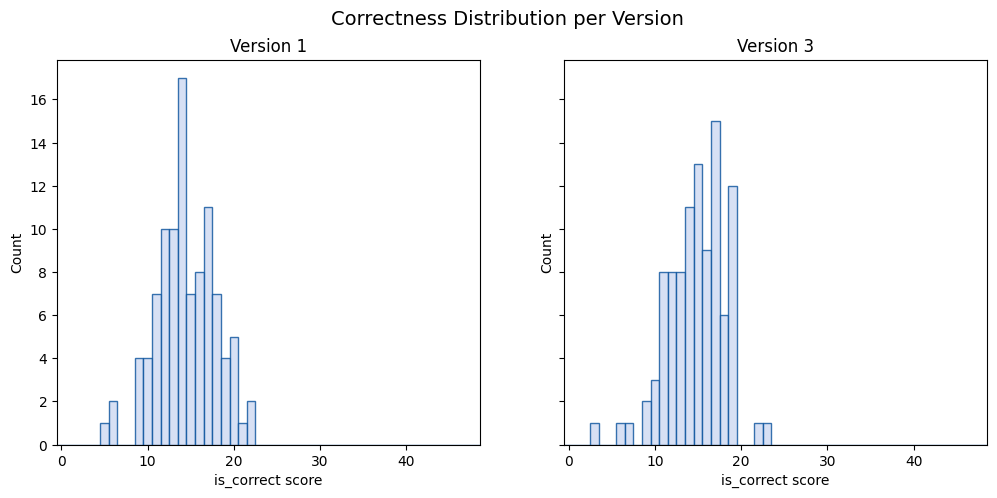

In [39]:
m1 = generate_10x10_result_matrix(df, versions=[1])
# m2 = generate_10x10_result_matrix(df, versions=[2])
m3 = generate_10x10_result_matrix(df, versions=[3])
plot_histograms([m1, m3], ["Version 1","Version 3"], max_score=48, main_title = "Correctness Distribution per Version")

### BP Matrices


Version 1
---------
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 81 : 8.0
  → 47 : 8.5
  → 61 : 8.5

Version 2
---------
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 72 : 7.5
  → 59 : 7.5
  → 3 : 8.5

Version 3
---------
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 68 : 7.5
  → 77 : 7.5
  → 83 : 8.0


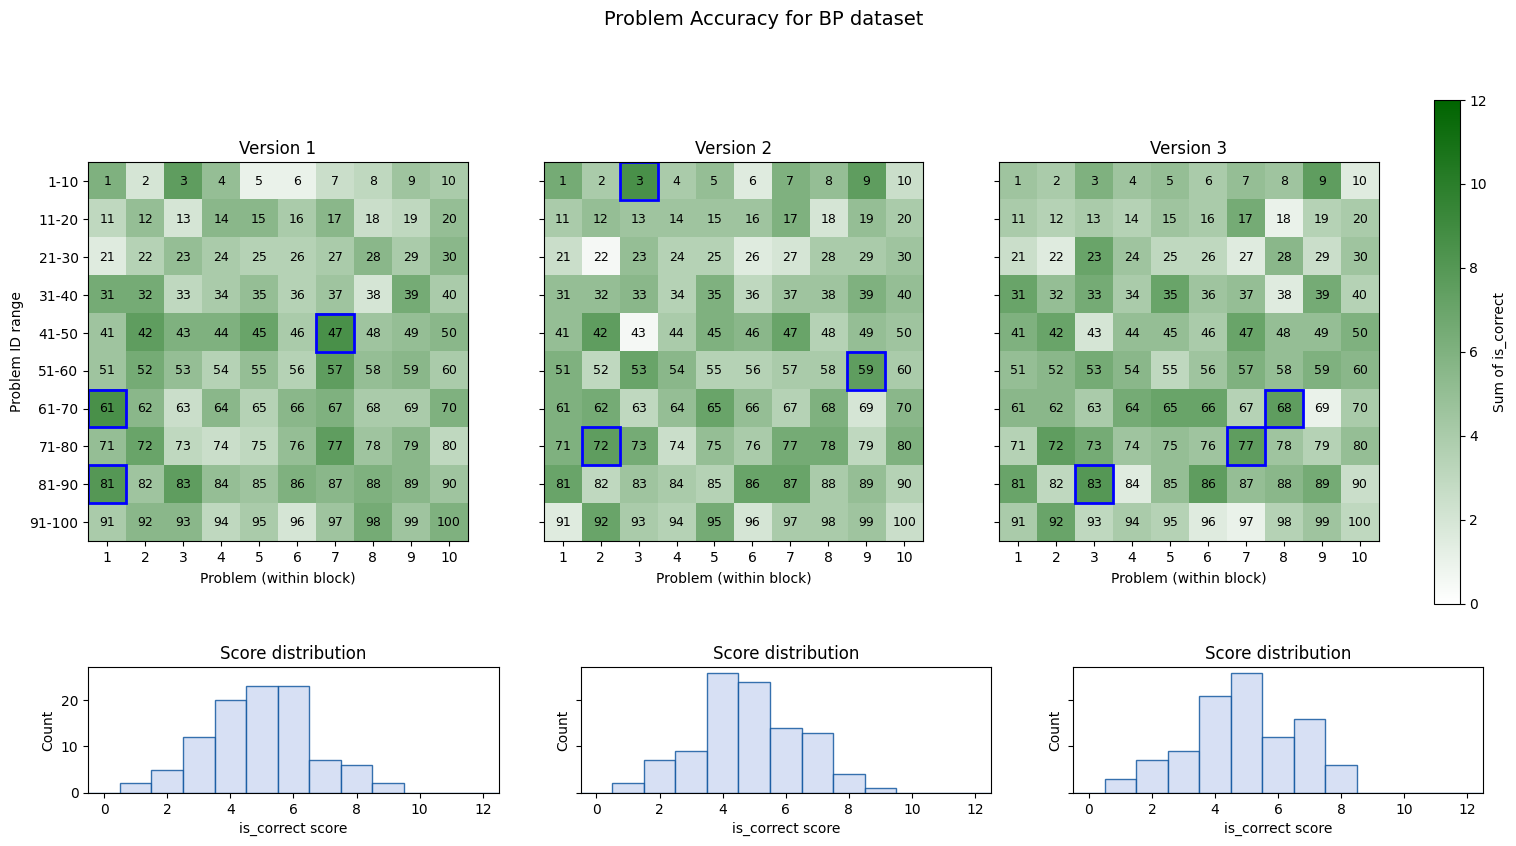

In [27]:
m1 = generate_10x10_result_matrix(df, dataset_name="bp", versions=[1])
m2 = generate_10x10_result_matrix(df, dataset_name="bp", versions=[2])
m3 = generate_10x10_result_matrix(df, dataset_name="bp", versions=[3])
plot_10x10_matrices([m1,m2,m3], ["Version 1","Version 2","Version 3"], max_score=12, main_title = "Problem Accuracy for BP dataset", highlight_extremes=True, zero_indexed_problem_ids=False)

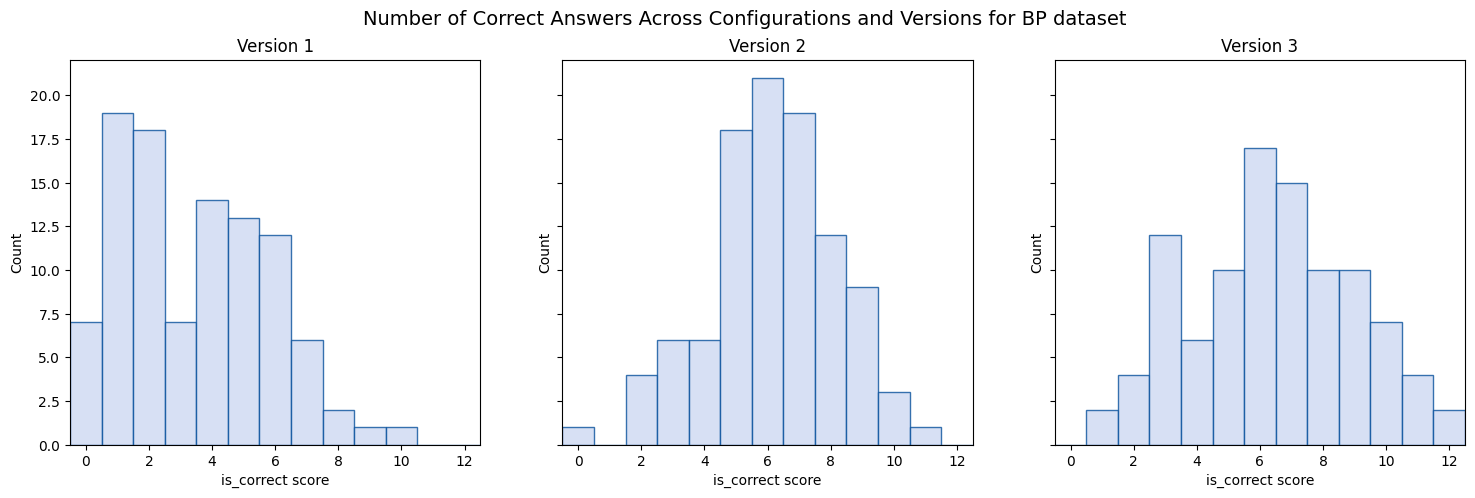

In [60]:
plot_histograms([m1,m2,m3], ["Version 1","Version 2","Version 3"], max_score=12, main_title = "Number of Correct Answers Across Configurations and Versions for BP dataset")

### RAVEN Matrices


Version 1
---------
Zero-value problems : 3
  → [np.int64(37), np.int64(74), np.int64(99)]
Top problems (problem_id : is_correct)
  → 22 : 5
  → 54 : 6
  → 53 : 6

Version 3
---------
Zero-value problems : 5
  → [np.int64(37), np.int64(72), np.int64(86), np.int64(95), np.int64(99)]
Top problems (problem_id : is_correct)
  → 20 : 6
  → 5 : 6
  → 47 : 6


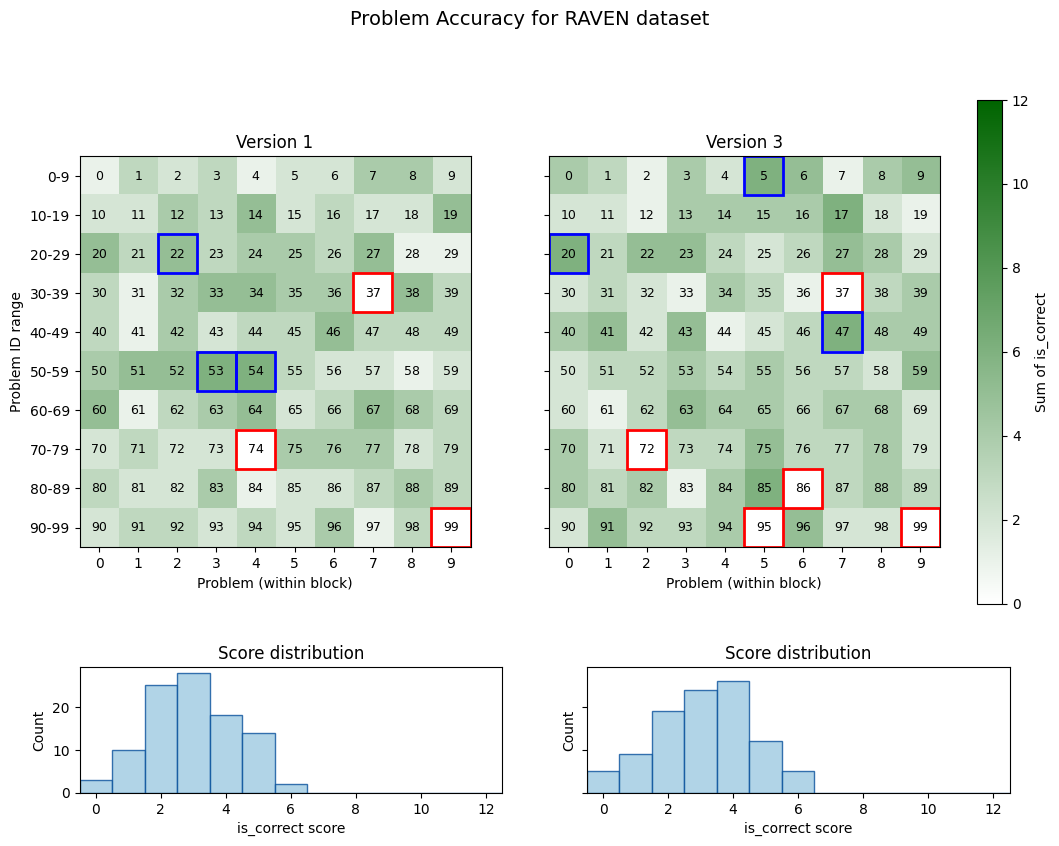

In [113]:
m1 = generate_10x10_result_matrix(df, dataset_name="raven", versions=[1])
m3 = generate_10x10_result_matrix(df, dataset_name="raven", versions=[3])
plot_10x10_matrices([m1,m3], ["Version 1","Version 3"], max_score=12, main_title = "Problem Accuracy for RAVEN dataset", highlight_extremes=True, zero_indexed_problem_ids=True)


Qwen7B
------
Zero-value problems : 6 → [np.int64(37), np.int64(44), np.int64(72), np.int64(86), np.int64(95), np.int64(99)]
Top problems (problem_id : is_correct)
  → 88 : 6
  → 23 : 7
  → 38 : 7

Intern8B
--------
Zero-value problems : 22 → [np.int64(0), np.int64(2), np.int64(10), np.int64(11), np.int64(21), np.int64(24), np.int64(28), np.int64(29), np.int64(37), np.int64(39), np.int64(40), np.int64(42), np.int64(45), np.int64(56), np.int64(71), np.int64(74), np.int64(75), np.int64(86), np.int64(90), np.int64(93), np.int64(98), np.int64(99)]
Top problems (problem_id : is_correct)
  → 47 : 4
  → 51 : 4
  → 20 : 4

LLaVA7B
-------
Zero-value problems : 41 → [np.int64(1), np.int64(3), np.int64(4), np.int64(7), np.int64(10), np.int64(11), np.int64(18), np.int64(19), np.int64(23), np.int64(25), np.int64(29), np.int64(32), np.int64(33), np.int64(36), np.int64(37), np.int64(38), np.int64(45), np.int64(46), np.int64(48), np.int64(51), np.int64(56), np.int64(57), np.int64(61), np.int64(62), 

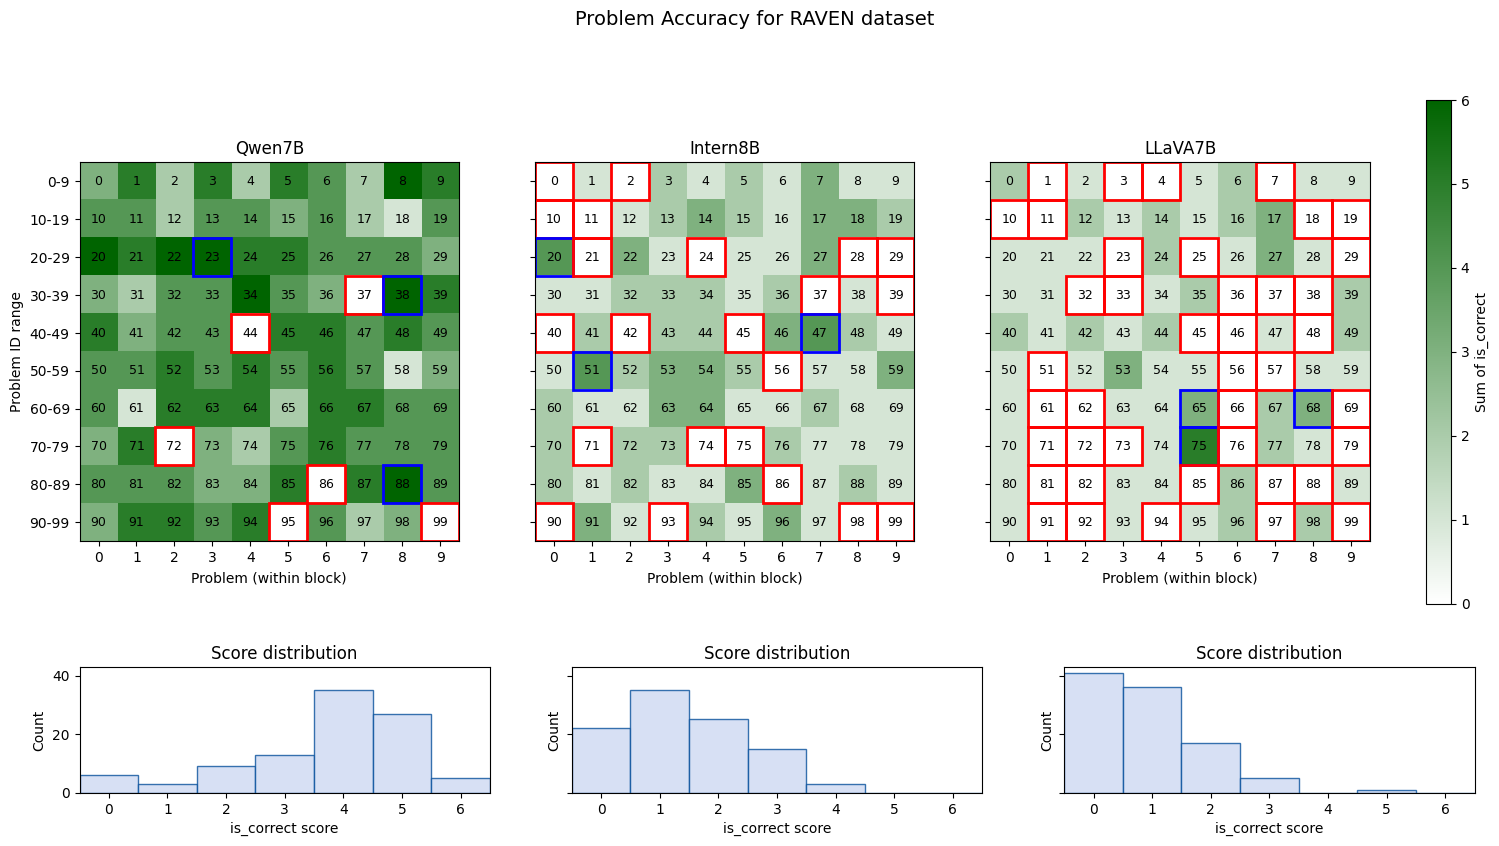

In [286]:
m1 = generate_10x10_result_matrix(df, dataset_name="raven", model_name="Qwen/Qwen2.5-VL-7B-Instruct", versions=[1,3])
m2 = generate_10x10_result_matrix(df, dataset_name="raven", model_name="OpenGVLab/InternVL3-8B", versions=[1,3])
m3 = generate_10x10_result_matrix(df, dataset_name="raven", model_name="llava-hf/llava-v1.6-mistral-7b-hf", versions=[1,3])
plot_10x10_matrices([m1,m2,m3], ["Qwen7B", "Intern8B", "LLaVA7B"], max_score=6, main_title = "Problem Accuracy for RAVEN dataset", highlight_extremes=True, zero_indexed_problem_ids=True)

### MARS Matrices


Ver 1
-----
Zero-value problems : 5
  → [np.int64(28), np.int64(44), np.int64(60), np.int64(96), np.int64(99)]
Top problems (problem_id : is_correct)
  → 87 : 7
  → 70 : 7
  → 58 : 7

Ver3
----
Zero-value problems : 2
  → [np.int64(67), np.int64(99)]
Top problems (problem_id : is_correct)
  → 23 : 6
  → 72 : 7
  → 58 : 8


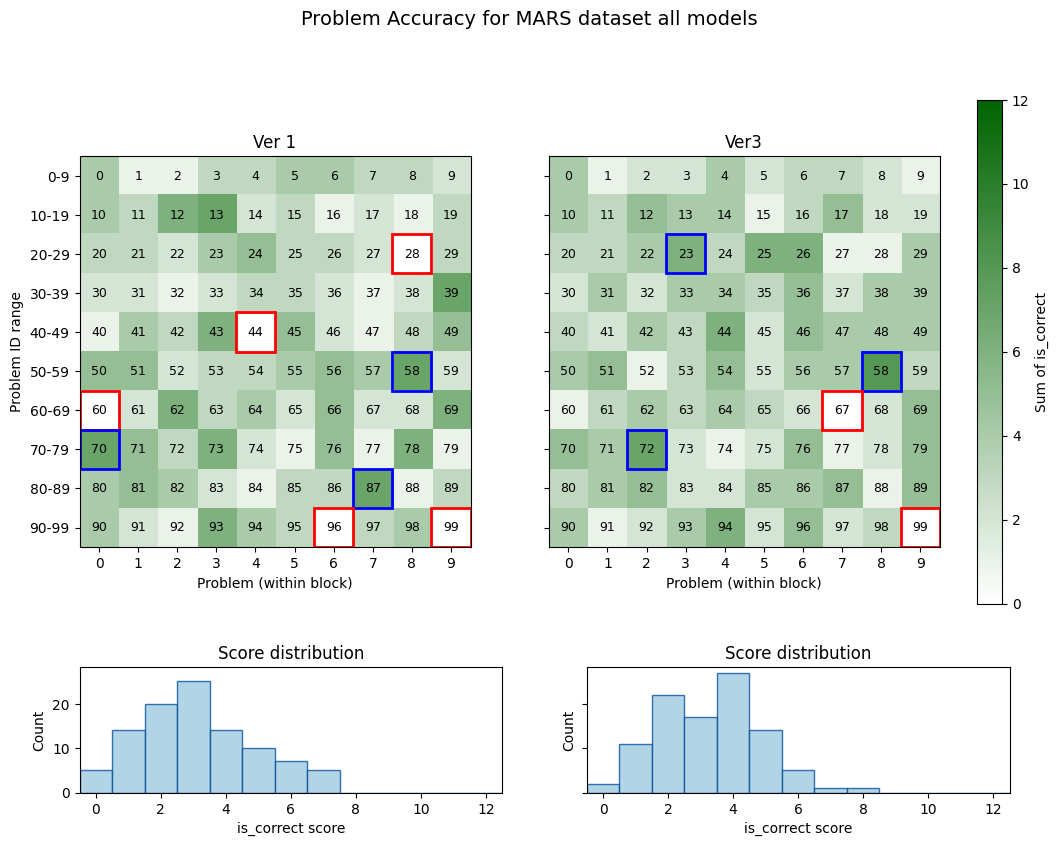

In [114]:
m_v1 = generate_10x10_result_matrix(df, dataset_name="marsvqa", versions=[1])
m_v3 = generate_10x10_result_matrix(df, dataset_name="marsvqa", versions=[3])
plot_10x10_matrices([m_v1, m_v3],["Ver 1", "Ver3"],  max_score=12, main_title = "Problem Accuracy for MARS dataset all models", highlight_extremes=True, zero_indexed_problem_ids=True)


Qwen7B
------
Zero-value problems : 19 → [np.int64(0), np.int64(1), np.int64(2), np.int64(8), np.int64(16), np.int64(27), np.int64(28), np.int64(30), np.int64(37), np.int64(41), np.int64(42), np.int64(52), np.int64(61), np.int64(63), np.int64(86), np.int64(91), np.int64(92), np.int64(96), np.int64(99)]
Top problems (problem_id : is_correct)
  → 43 : 6
  → 87 : 7
  → 49 : 7

Intern8B
--------
Zero-value problems : 13 → [np.int64(1), np.int64(15), np.int64(32), np.int64(33), np.int64(37), np.int64(46), np.int64(60), np.int64(74), np.int64(77), np.int64(83), np.int64(84), np.int64(88), np.int64(99)]
Top problems (problem_id : is_correct)
  → 12 : 5
  → 58 : 6
  → 48 : 6

LLaVA7B
-------
Zero-value problems : 18 → [np.int64(8), np.int64(11), np.int64(12), np.int64(15), np.int64(18), np.int64(28), np.int64(30), np.int64(35), np.int64(48), np.int64(54), np.int64(60), np.int64(66), np.int64(67), np.int64(75), np.int64(77), np.int64(84), np.int64(95), np.int64(99)]
Top problems (problem_id : 

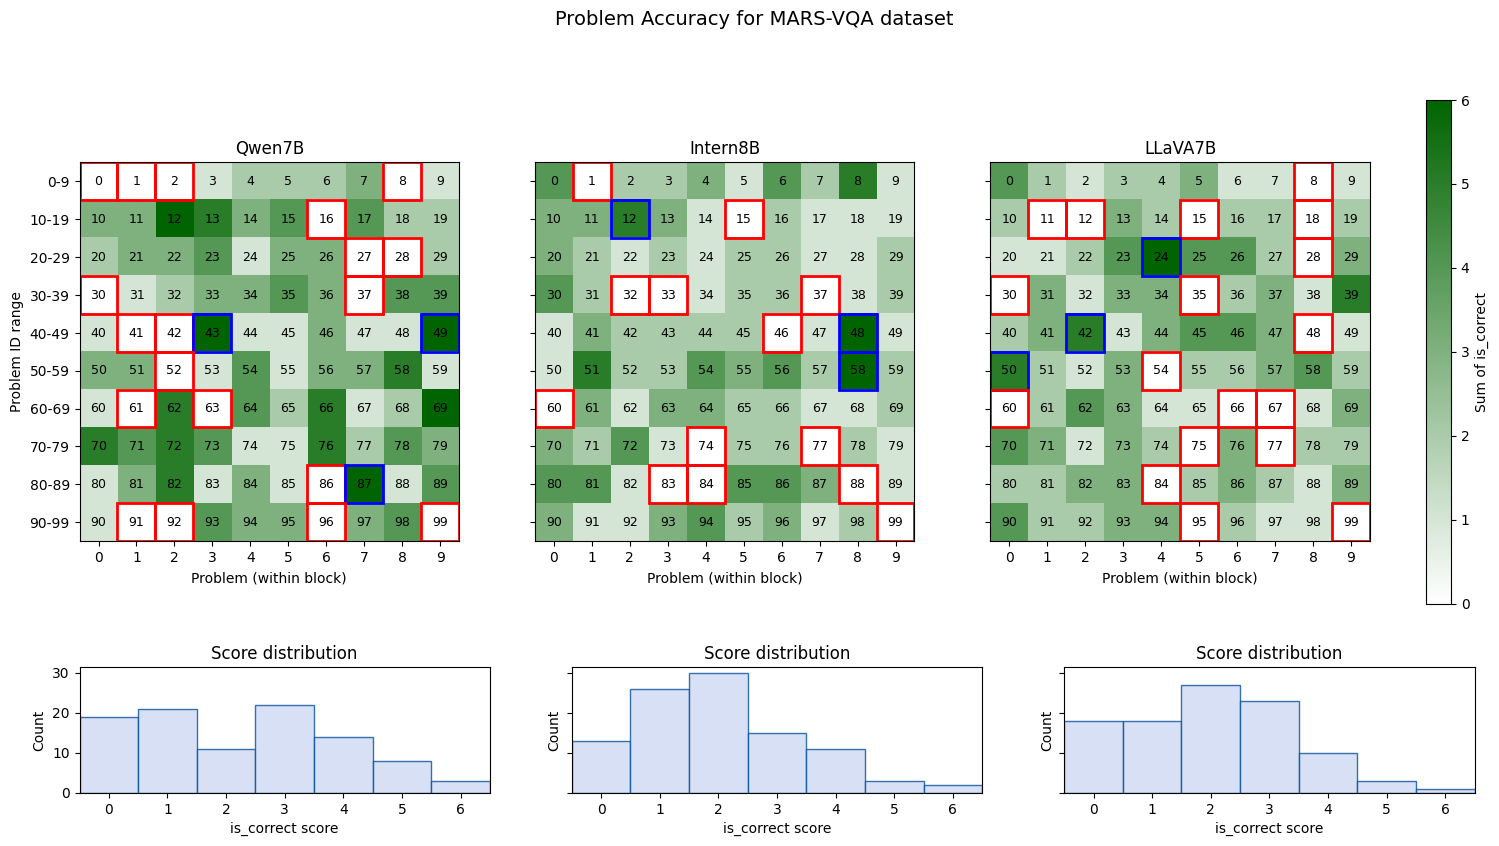

In [287]:
m1 = generate_10x10_result_matrix(df, dataset_name="marsvqa", model_name="Qwen/Qwen2.5-VL-7B-Instruct", versions=[1,3])
m2 = generate_10x10_result_matrix(df, dataset_name="marsvqa", model_name="OpenGVLab/InternVL3-8B", versions=[1,3])
m3 = generate_10x10_result_matrix(df, dataset_name="marsvqa", model_name="llava-hf/llava-v1.6-mistral-7b-hf", versions=[1,3])
plot_10x10_matrices([m1,m2,m3], ["Qwen7B", "Intern8B", "LLaVA7B"], max_score=6, main_title = "Problem Accuracy for MARS-VQA dataset", highlight_extremes=True, zero_indexed_problem_ids=True)

## Boxplots

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correctness_boxplots(
    df,
    dataset_names=None,
    model_names=None,
    strategy_names=None,
    type_name=None,
    versions=None,
    value_col="percentage",
    figsize=(10,6),
    title="Correctness Boxplots",
    x_column="strategy_name",
    hue=None,
    palette=["#83ab7c", "#ced9f2", "#f6c4e1", "#fdf3c7"],
    font_size=10
):
    
    df_filtered = df.copy()
    if hue is None:
        palette = [palette[0]]

    if x_column == "model_name":
        df_filtered["model_name"] = df_filtered["model_name"].apply(shorten_model_name)

    filters = {
        "dataset_name": dataset_names,
        "model_name": model_names,
        "strategy_name": strategy_names,
        "type_name": type_name,
        "version": versions
    }

    plt.rcParams.update({'font.size': font_size})

    for col, val in filters.items():
        if val is None:
            continue
        if isinstance(val, (list, tuple, set, range)):
            df_filtered = df_filtered[df_filtered[col].isin(val)]
        else:
            df_filtered = df_filtered[df_filtered[col] == val]

    if df_filtered.empty:
        raise ValueError("No data left after filtering. Check your filter selections.")
    
    plt.figure(figsize=figsize)
    sns.boxplot(
        data=df_filtered,
        x=x_column,
        y=value_col,
        hue=hue,
        palette=palette
    )

    plt.title(title)
    plt.ylabel("Correctness (%)")
    plt.ylim(0, 100)
    plt.xlabel(x_column.replace("_", " ").title())
    
    if hue is not None:
        plt.legend(title=hue)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


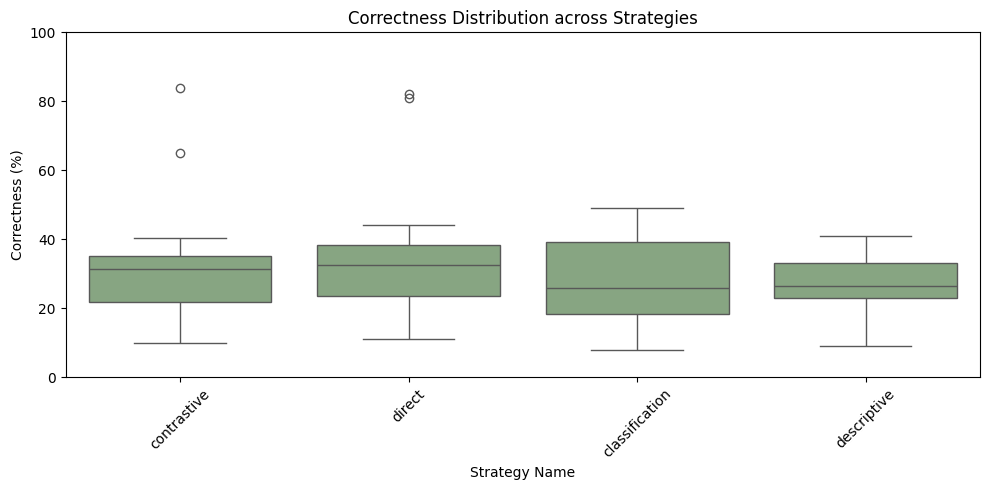

In [293]:
plot_correctness_boxplots(
    accuracy_df,
    versions=[1,3],
    value_col="percentage",
    figsize=(10,5),
    title="Correctness Distribution across Strategies",
    x_column="strategy_name",
    # hue="dataset_name"
)

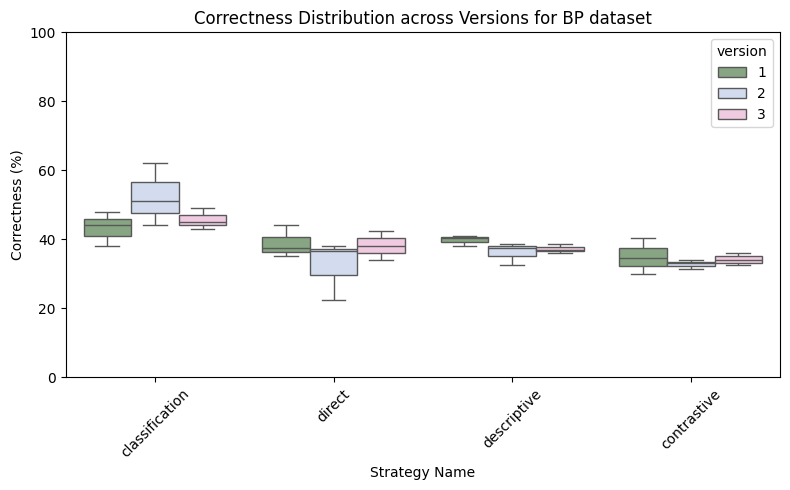

In [45]:
plot_correctness_boxplots(
    accuracy_df[accuracy_df["dataset_name"]=="bp"],
    versions=[1,2,3],
    value_col="percentage",
    figsize=(8,5),
    title="Correctness Distribution across Versions for BP dataset",
    x_column="strategy_name",
    hue="version"
)

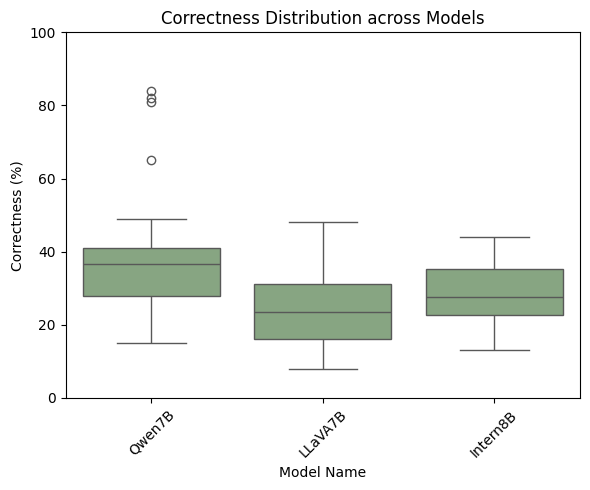

In [267]:
plot_correctness_boxplots(
    accuracy_df,
    versions=[1,3],
    value_col="percentage",
    figsize=(6,5),
    title="Correctness Distribution across Models",
    x_column="model_name",
    # hue="dataset_name"
)

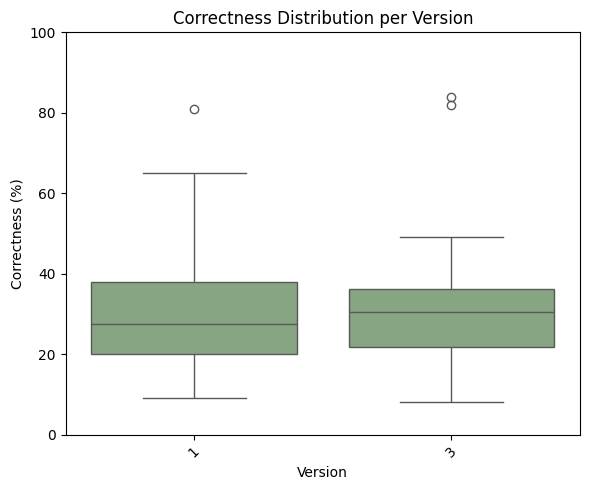

In [48]:
plot_correctness_boxplots(
    accuracy_df,
    versions=[1,3],
    value_col="percentage",
    figsize=(6,5),
    title="Correctness Distribution per Version",
    x_column="version",
    # hue="dataset_name"
)

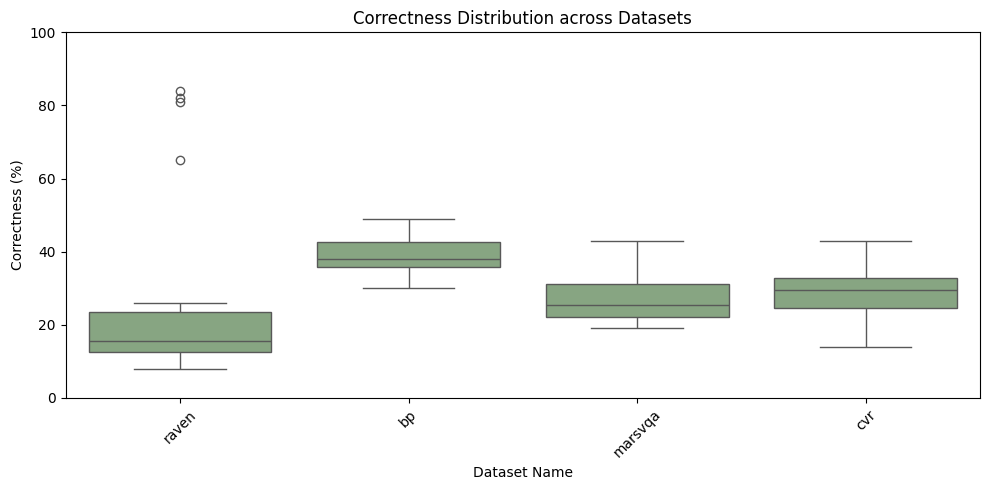

In [285]:
plot_correctness_boxplots(
    accuracy_df,
    versions=[1,3],
    value_col="percentage",
    figsize=(10,5),
    title="Correctness Distribution across Datasets",
    x_column="dataset_name"
)

In [ ]:
# mean_accuracy = mean_accuracy.sort_values("mean_percentage", ascending=False)
# mean_accuracy.to_csv('results/accuracy_stats.csv', index=False)   

## Ensembles

In [ ]:
import numpy as np

df_ensembles["ensemble_model"] = np.where(
    df_ensembles["version"] >= 100,
    "Qwen7B",
    "Intern8B"
)

In [69]:
group_cols=["type_name", "dataset_name", "ens_members_config_number", "seed", "ensemble_model"]
accuracy_df_ensembles = accuracy_stats(df_ensembles, group_cols=group_cols)
# print(accuracy_df_ensembles)

agg_group_cols = ["type_name", "ens_members_config_number", "dataset_name"]
mean_accuracy_conf = accuracy_df_ensembles.groupby(agg_group_cols).agg(
    mean_percentage=("percentage", "mean"),
    sd_percentage=("percentage", "std"),
    total_score=("total_score", "sum"),
    total_possible=("all_possible", "sum")
).reset_index()
# print(mean_accuracy_conf.sort_values("mean_percentage", ascending=False))

agg_group_cols_2 = ["type_name", "dataset_name", "ensemble_model"]
mean_accuracy_seed = accuracy_df_ensembles.groupby(agg_group_cols_2).agg(
    mean_percentage=("percentage", "mean"),
    sd_percentage=("percentage", "std"),
    total_score=("total_score", "sum"),
    total_possible=("all_possible", "sum")
).reset_index()
# print(mean_accuracy_seed.sort_values("mean_percentage", ascending=False))


agg_group_top = ["type_name", "ensemble_model", "ens_members_config_number", "dataset_name"]
mean_accuracy_top = accuracy_df_ensembles.groupby(agg_group_top).agg(
    mean_percentage=("percentage", "mean"),
    sd_percentage=("percentage", "std"),
    total_score=("total_score", "sum"),
    total_possible=("all_possible", "sum")
).reset_index()

In [77]:
print(mean_accuracy_top[mean_accuracy_top["dataset_name"] == "raven"].sort_values("mean_percentage", ascending=False))

                type_name               ensemble_model  \
223  reasoning_with_image                     Intern8B   
73               majority                     Intern8B   
108              majority  Qwen/Qwen2.5-VL-7B-Instruct   
239  reasoning_with_image                     Intern8B   
215  reasoning_with_image                     Intern8B   
..                    ...                          ...   
11             confidence                     Intern8B   
120              majority  Qwen/Qwen2.5-VL-7B-Instruct   
85               majority                     Intern8B   
50             confidence  Qwen/Qwen2.5-VL-7B-Instruct   
15             confidence                     Intern8B   

     ens_members_config_number dataset_name  mean_percentage  sd_percentage  \
223                        3.0        raven             85.0            NaN   
73                         0.0        raven             84.3       0.948683   
108                        0.0        raven             84.3      

In [71]:
mean_accuracy_conf.to_csv('results/accuracy_stats_ensembles_conf.csv', index=False)   
mean_accuracy_seed.to_csv('results/accuracy_stats_ensembles_seed.csv', index=False)
accuracy_df_ensembles.to_csv('results/accuracy_stats_ensembles.csv', index=False)